In [1]:
%load_ext autoreload
%autoreload 1
%aimport src.my, src.text_utils

import sys
import numpy as np
import pandas as pd

import os
import gc
import matplotlib.pyplot as plt
import importlib
import pickle

import src.text_utils as tu
import src.my as my
from src.my import p
from tqdm.notebook import tqdm

pd.set_option('display.max_rows', 200)
pd.set_option("max_colwidth", 45)
pd.set_option("display.precision", 1)
pd.options.display.float_format = "{:.3f}".format
# pd.set_option("display.max_rows", 5)
# pd.reset_option("display.max_rows")

from sklearn.model_selection import train_test_split

# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True)

dir_data = 'data/'
dir_out = 'out/'
os.makedirs(dir_out, exist_ok=True)

SEED = 34
N_CPU = os.cpu_count()

np.random.seed(SEED)
rng = np.random.default_rng(SEED)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


- Загружаем датасеты, делаем label encoding для таргета, так как в DL моделях удобно когда таргет с нуля и непрерывен. 
- Также кодируем для shop_title для использования в nn.Embedding.
- Удаляем признаки 'rating','sale', так как они меняются в течение времени, и у новых товаров rating нет.

In [2]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_parquet(dir_data+'train.parquet')
df = df.astype({'product_id':np.int32,'category_id':np.int32,'shop_id':np.int32, 'rating':np.float32}).drop(columns=['rating','sale']).reset_index(drop=True).copy()

test = pd.read_parquet(dir_data+'test.parquet')
test = test.astype({'product_id':np.int32,'shop_id':np.int32, 'rating':np.float32}).drop(columns=['rating','sale']).reset_index(drop=True).copy()

encoders = {'cat_enc': LabelEncoder(), 'shop_enc': LabelEncoder()}
df['category_id'] =encoders['cat_enc'].fit_transform(df['category_id'])

encoders['shop_enc'].fit(pd.concat([df['shop_title'],test['shop_title']]))

df['shop_id'] = encoders['shop_enc'].transform(df['shop_title']) + 1
test['shop_id'] = encoders['shop_enc'].transform(test['shop_title']) + 1

my.save_pickle(dir_out+'encoders.pik', encoders)

p(df.shape)
df[:3]

(91120, 6)


,product_id,category_id,shop_id,shop_title,text_fields,category_name
0,325286,251,493,Aksik,"{""title"": ""Зарядный кабель Borofone BX1 L...",Все категории->Электроника->Смартфоны и т...
1,888134,748,6081,Sela,"{""title"": ""Трусы Sela"", ""description"": ""Т...",Все категории->Одежда->Женская одежда->Бе...
2,1267173,560,11015,ЮНЛАНДИЯ канцтовары,"{""title"": ""Гуашь \""ЮНЫЙ ВОЛШЕБНИК\"", 12 ц...",Все категории->Хобби и творчество->Рисова...


Чистим названия категорий, приводим к нижнему регистру - нужно для матрицы смежности семантического графа в модели HUSE

In [3]:
df['category_name'] = tu.clean_cat_name(df['category_name'])
df[:3]

,product_id,category_id,shop_id,shop_title,text_fields,category_name
0,325286,251,493,Aksik,"{""title"": ""Зарядный кабель Borofone BX1 L...",электроника смартфоны телефоны аксессуары...
1,888134,748,6081,Sela,"{""title"": ""Трусы Sela"", ""description"": ""Т...",одежда женская одежда белье купальники трусы
2,1267173,560,11015,ЮНЛАНДИЯ канцтовары,"{""title"": ""Гуашь \""ЮНЫЙ ВОЛШЕБНИК\"", 12 ц...",хобби творчество рисование краски пигменты


Датасет по категориям несбалансированный, много категорий <5 товаров, есть и больше 1000 товаров.

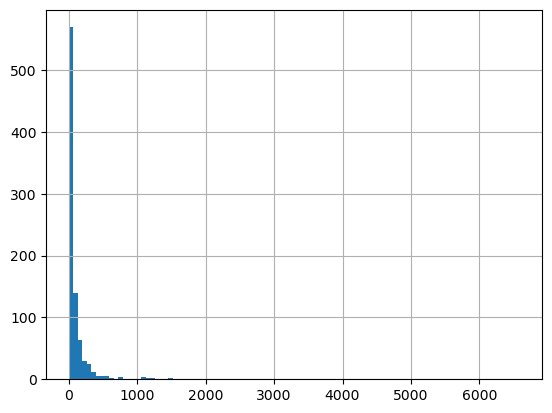

In [10]:
_ = df['category_id'].value_counts().hist(bins=100)

Поэтому важно сделать разбиение на фолды со стратификацией, чтобы алгоритмы при тренировке охватывали образцы с бОльшим количеством разнообразных категорий. Выбрал 5 фолдов с учетом медленной работы алгоритмов на этой конкретной задаче.

In [13]:
df = my.add_folds(df, strat_col = 'category_id', n_folds=5, random_state=SEED)
df[:2]

StratifiedKFold


,product_id,category_id,shop_id,shop_title,text_fields,category_name,fold
0,325286,251,493,Aksik,"{""title"": ""Зарядный кабель Borofone BX1 L...",электроника смартфоны телефоны аксессуары...,4
1,888134,748,6081,Sela,"{""title"": ""Трусы Sela"", ""description"": ""Т...",одежда женская одежда белье купальники трусы,3


- Объединяем всю текстовую информацию из поля text_fields в один текст, добавляем к нему название магазина, так как в нем часто бывают "подсказки" для текстовых моделей, например: "ЮНЛАНДИЯ канцтовары"
- При этом удаляем html теги и малоинформативную информацию, например цвета.

In [14]:
df['text_fields'] = df['text_fields'].apply(tu.join_text_fields) + ' ' + df['shop_title']
df[:3]

,product_id,category_id,shop_id,shop_title,text_fields,category_name,fold
0,325286,251,493,Aksik,Зарядный кабель Borofone BX1 Lightning дл...,электроника смартфоны телефоны аксессуары...,4
1,888134,748,6081,Sela,Трусы Sela Трусы-слипы из эластичного бес...,одежда женская одежда белье купальники трусы,3
2,1267173,560,11015,ЮНЛАНДИЯ канцтовары,"Гуашь ""ЮНЫЙ ВОЛШЕБНИК"", 12 цветов по 35 м...",хобби творчество рисование краски пигменты,3


Подготовил две версии текста из text_fields:
- одну без лемматизации для берта
- вторую с лемматизацией для fasttext (у меня он без леммматизации хуже показывал качество) и tf-idf
- в обоих версиях удаляются стоп-слова, цифры, знаки препинания

In [15]:
# text for bert
df['text'] = tu.clean_text(df['text_fields'],do_lemma=False,min_sim=3)
# text for fasttext and tf-idf
df['text_ft'] = tu.clean_text(df['text_fields'], do_lemma=True,min_sim=2)
df[:2]

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,product_id,category_id,shop_id,shop_title,text_fields,category_name,fold,text,text_ft
0,325286,251,493,Aksik,Зарядный кабель Borofone BX1 Lightning дл...,электроника смартфоны телефоны аксессуары...,4,зарядный кабель borofone bx1 lightning ай...,зарядный кабель borofone bx1 lightning ай...
1,888134,748,6081,Sela,Трусы Sela Трусы-слипы из эластичного бес...,одежда женская одежда белье купальники трусы,3,трусы sela трусы слипы эластичного бесшов...,трус sela трус слип эластичный бесшовный ...


Сохраняем подготовленный файл prepared_df.pq:

In [16]:
df.drop(columns=['text_ft','text_fields','shop_title']).to_parquet(dir_out+'prepared_df.pq', index=False)

Такую же очистку делаем и для тестового файла:

In [18]:
test['text_fields'] = test['text_fields'].apply(tu.join_text_fields) + ' ' + test['shop_title']
test['text'] = tu.clean_text(test['text_fields'],do_lemma=False,min_sim=3)

p(test.shape)
test[:3]

(16860, 5)


,product_id,shop_id,shop_title,text_fields,text
0,1997646,6217,Sky_Electronics,"Светодиодная лента Smart led Strip Light,...",светодиодная лента smart led strip light ...
1,927375,1796,Di-Di Market,Стекло ПЛЕНКА керамик матовое Honor 50 li...,стекло пленка керамик матовое honor lite ...
2,1921513,7133,VisionStore,"Проводные наушники с микрофоном jack 3.5,...",проводные наушники микрофоном jack ios an...


In [19]:
test.drop(columns=['text_fields','shop_title']).to_parquet(dir_out+'prepared_test.pq', index=False)

- В качестве бейзлайна я использовал fasttext, так как он быстрый и показал качество сравнимое с более сложными моделями
- Для каждого фолда сохранил транировочную и валидационную часть на диск, в требуемом fasttext формате, но т.к. это бейзлайн, то на одном фолде проверил его работу.

In [21]:
os.makedirs(dir_out+'fasttext', exist_ok=True)

for fold in df.fold.unique():
    print(fold, end=' ')
    Xy_train = df.loc[df.fold!=fold,['category_id', 'text_ft']].copy()
    Xy_val = df.loc[df.fold==fold,['category_id', 'text_ft']].copy()

    Xy_train['category_id'] = '__label__' + Xy_train['category_id'].astype(str)
    Xy_val['category_id'] = '__label__' + Xy_val['category_id'].astype(str)

    Xy_train.to_csv(dir_out + f'fasttext/Xy_train_ft_f{fold}.txt',index=False, header = False, sep="\t")
    Xy_val.to_csv(dir_out + f'fasttext/Xy_val_ft_f{fold}.txt',index=False, header = False, sep="\t")

4 3 2 0 1 

In [29]:
Xy_train[:3]

,category_id,text_ft
0,__label__251,зарядный кабель borofone bx1 lightning ай...
1,__label__748,трус sela трус слип эластичный бесшовный ...
2,__label__560,гуашь юный волшебник цвет мл больший бано...


Возпользуемся встроенным автоматическим подбором гиперпараметров (он подбирает для метрики f1 - я проверил, очень похоже, что это именно weighted):

In [ ]:
import fasttext

FOLD = 0

model = fasttext.train_supervised(input=f'out/fasttext/Xy_train_ft_f{FOLD}.txt', autotuneValidationFile=f'out/fasttext/Xy_val_ft_f{FOLD}.txt', autotuneDuration=1000, verbose=5)

c подобранными параметрами получаем f1 ~ 0.85

In [28]:
model = fasttext.train_supervised(input=dir_out +f'fasttext/Xy_train_ft_f{FOLD}.txt', lr=0.5, neg=150, epoch=25, dim=100, wordNgrams=1)

_, precision, recall = model.test(dir_out + f'fasttext/Xy_val_ft_f{FOLD}.txt')
F1 = (2*precision*recall) / (precision+recall)
F1, _, precision, recall

Read 5M words
Number of words:  80340
Number of labels: 872
Progress: 100.0% words/sec/thread:  266660 lr:  0.000000 avg.loss:  0.407955 ETA:   0h 0m 0s


(0.8499615848973768, 18222, 0.8499615848973768, 0.8499615848973768)

Дальше попробовал обрезать текст, оставляя первые 10-100 слов, но именно с такими гиперпараметрами это мало меняло результат

In [37]:
FOLD = 0
Xy_train = pd.read_csv(dir_out + f'fasttext/Xy_train_ft_f{FOLD}.txt',header = None, sep="\t")
Xy_train[1] = Xy_train[1].apply(lambda x:x.split())
Xy_val = pd.read_csv(dir_out + f'fasttext/Xy_val_ft_f{FOLD}.txt',header = None, sep="\t")
Xy_val[1] = Xy_val[1].apply(lambda x:x.split())
Xy_train[:3]

,0,1
0,__label__251,"[зарядный, кабель, borofone, bx1, lightni..."
1,__label__748,"[трус, sela, трус, слип, эластичный, бесш..."
2,__label__560,"[гуашь, юный, волшебник, цвет, мл, больши..."


In [38]:
for n_words in range(10, 101, 20):
    Xy_train['truncated_text'] = Xy_train[1].apply(lambda x: ' '.join(x[:n_words]))
    Xy_val['truncated_text'] = Xy_val[1].apply(lambda x: ' '.join(x[:n_words]))

    Xy_train[[0,'truncated_text']].to_csv(dir_out + f'fasttext/Xy_train_tr_f{FOLD}.txt',index=False, header = False, sep="\t")
    Xy_val[[0,'truncated_text']].to_csv(dir_out + f'fasttext/Xy_val_tr_f{FOLD}.txt',index=False, header = False, sep="\t")

    model = fasttext.train_supervised(input=dir_out +f'fasttext/Xy_train_tr_f{FOLD}.txt', lr=0.5, neg=150, epoch=25, dim=100, wordNgrams=1)

    _, precision, recall = model.test(dir_out + f'fasttext/Xy_val_tr_f{FOLD}.txt')
    F1 = (2*precision*recall) / (precision+recall)

    print(f'n_words: {n_words} -> F1: {F1}')

Read 0M words
Number of words:  30339
Number of labels: 872
Progress:  99.9% words/sec/thread:   47572 lr:  0.000396 avg.loss:  0.303947 ETA:   0h 0m 0s

n_words: 10 -> F1: 0.8435407748874987


Progress: 100.0% words/sec/thread:   47517 lr:  0.000000 avg.loss:  0.303715 ETA:   0h 0m 0s
Read 2M words
Number of words:  47255
Number of labels: 872
Progress: 100.0% words/sec/thread:  111437 lr:  0.000000 avg.loss:  0.345181 ETA:   0h 0m 0s


n_words: 30 -> F1: 0.8466139830973548


Read 3M words
Number of words:  56533
Number of labels: 872
Progress: 100.0% words/sec/thread:  161554 lr:  0.000000 avg.loss:  0.383458 ETA:   0h 0m 0s


n_words: 50 -> F1: 0.8486993743826144


Read 3M words
Number of words:  62680
Number of labels: 872
Progress:  99.9% words/sec/thread:  192255 lr:  0.000742 avg.loss:  0.391289 ETA:   0h 0m 0s

n_words: 70 -> F1: 0.8482603446383493


Progress: 100.0% words/sec/thread:  192200 lr:  0.000000 avg.loss:  0.390792 ETA:   0h 0m 0s
Read 4M words
Number of words:  66944
Number of labels: 872
Progress: 100.0% words/sec/thread:  213515 lr:  0.000000 avg.loss:  0.402865 ETA:   0h 0m 0s


n_words: 90 -> F1: 0.849632312589178


### Изображения

Проверил, что они все одного размера, имеют светлый фон, и объект находится почти всегда в центре, то есть это дает нам больше свободы для аугментаций, связанных с перемещением объекта на фото.

In [39]:
from PIL import Image
train_images = 'data/images/train/'
test_images = 'data/images/test/'

for path in os.listdir(train_images):
    if path.endswith('.jpg'):
        im = Image.open(train_images+path)
        if im.size != (512,512):
            print('new size')

print('File count train:', len(os.listdir(train_images)))
print('File count test:', len(os.listdir(test_images)))

File count train: 91120
File count test: 16860


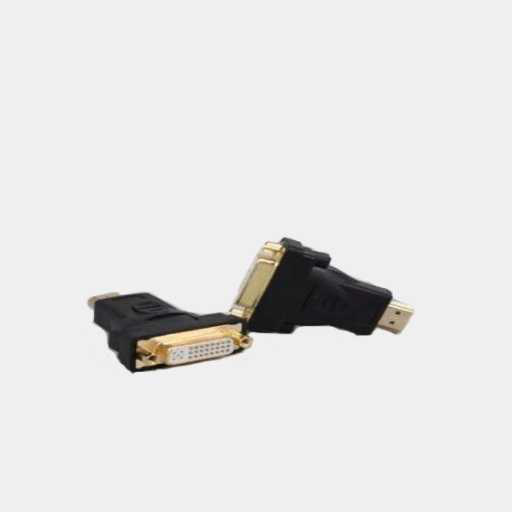

In [42]:
image = Image.open(test_images+'14841.jpg')
image